In [1]:
!pip install --upgrade tensorflow-gpu

^C


In [2]:
# CREDITS - https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/

# Load the TensorBoard notebook extension
%reload_ext tensorboard

import os
import datetime
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.python.keras.metrics import Recall, Precision
from tensorflow.python.keras.optimizer_v2.nadam import Nadam
from models.metrics.dice import dice_coefficient, dice_loss
import numpy as np

from utils.Dataset import MIRDCRicord1aDataset, array_to_rgb, read_image, read_mask
from models.UMobileNetV2 import build_model

In [3]:
import tensorflow as tf

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
dataset_path = os.path.abspath(os.path.join(os.pardir, 'data'))
dataset = MIRDCRicord1aDataset('\\\\?\\' + dataset_path)

In [5]:
IMAGE_SIZE = dataset.IMAGE_SIZE
EPOCHS = 30
BATCH = 8
LR = 1e-4

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = dataset.load_data()

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  40
Validation data:  30
Testing data:  30


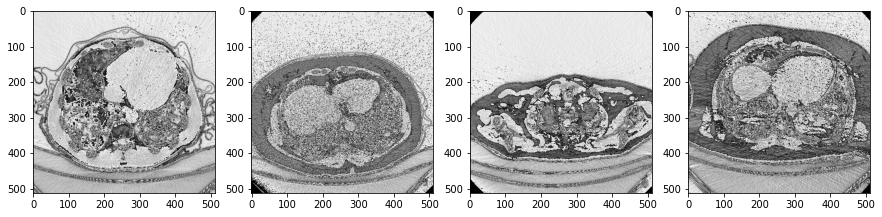

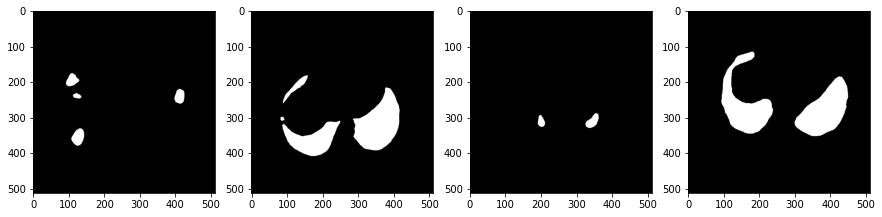

In [6]:
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 4, 1)
plt.imshow(array_to_rgb(train_x[0]))
fig.add_subplot(1, 4, 2)
plt.imshow(array_to_rgb(train_x[1]))
fig.add_subplot(1, 4, 3)
plt.imshow(array_to_rgb(train_x[2]))
fig.add_subplot(1, 4, 4)
plt.imshow(array_to_rgb(train_x[3]))

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 4, 1)
plt.imshow(array_to_rgb(train_y[0]))
fig.add_subplot(1, 4, 2)
plt.imshow(array_to_rgb(train_y[1]))
fig.add_subplot(1, 4, 3)
plt.imshow(array_to_rgb(train_y[2]))
fig.add_subplot(1, 4, 4)
plt.imshow(array_to_rgb(train_y[3]))

In [7]:
train_dataset = dataset.tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = dataset.tf_dataset(valid_x, valid_y, batch=BATCH)

In [8]:
opt = Nadam(LR)
metrics = [dice_coefficient, Recall(), Precision()]
model = build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 16)   432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 16)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [9]:
log_dir = os.path.join(os.getcwd(), "logs", "umobilenetv2","fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint_path = os.path.join(os.getcwd(), "checkpoints", "umobilenetv2", "model_checkpoint_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True, save_weights_only=True, monitor='loss', verbose=1)
]

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1
    
try:
  # Do this if you have a GPU
  with tf.device(tf.test.gpu_device_name()):
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks,
        verbose=1
    )
except RuntimeError as e:
    # On error tun without GPU
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/30


In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x, IMAGE_SIZE)
    y = read_mask(y, IMAGE_SIZE)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    img_plot = plt.imshow(image)


In [ ]:
%tensorboard --logdir 'logs/umobilenetv2/fit'